In [1]:
catName = 'low'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories
cat = categories[catName]

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 7*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
m_mu = 0.1056583755
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026
m_jpsi = 3.096916
dm = m_Dst - m_D0

In [5]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
# df = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_200327_{}.root'.format(cat.name)))

In [8]:
loc = '../data/cmsMC_private/'
# loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
# loc += 'BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
loc += 'BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/'
loc += 'ntuples_B2DstMu/skimmed/{}'.format(cat.name)
df_old = pd.DataFrame(rtnp.root2array(loc+'_skip21.root'))
df_bare = pd.DataFrame(rtnp.root2array(loc+'_skip17_bare.root'))
df_corr = pd.DataFrame(rtnp.root2array(loc+'_skip17_corr.root'))

In [9]:
# os.system('echo Old; cat '+loc+'.log; echo')
# os.system('echo Bare; cat '+loc+'_bare.log; echo')
# os.system('echo Corr; cat '+loc+'_corr.log; echo')

Old is expected to have a slightly lower effieciency because the D*pis mass was not computed after the refit with the muon

In [10]:
print '  '.join(df_old.columns)
print ''
print '  '.join(df_bare.columns)

index  q2  Est_mu  M2_miss  mu_pt  mu_eta  mu_phi  mu_sigdxy  B_pt  B_eta  B_phi  Dst_pt  Dst_eta  Dst_phi  D0_pt  D0_eta  D0_phi  pi_pt  pi_eta  pi_phi  pi_IP  K_pt  K_eta  K_phi  K_IP  pval_piK  sigdxy_vtxD0_PV  pis_pt  pis_eta  pis_phi  pis_IP  pval_D0pis  mass_piK  mass_D0pis  mass_D0pismu  pval_D0pismu  cos_D0pismu_PV  cosT_D0pismu_PV  N_goodAddTks  tkMassHad_0  tkMassHad_1  tkMassMuTk_0  tkMassMuTk_1  tkMassVis_0  tkMassVis_1  tkPt_0  tkPt_1  cat_low  cat_mid  cat_high  N_vtx  MC_q2  MC_Est_mu  MC_M2_miss  MC_B_pt  MC_B_eta  MC_B_phi  MC_Dst_pt  MC_Dst_eta  MC_Dst_phi  MC_mu_pt  MC_mu_eta  MC_mu_phi  MC_mu_IP  MC_pi_pt  MC_pi_eta  MC_pi_phi  MC_K_pt  MC_K_eta  MC_K_phi  MC_pis_pt  MC_pis_eta  MC_pis_phi  MC_idxMatch

index  q2  Est_mu  M2_miss  mu_pt  mu_eta  mu_phi  mu_sigdxy  B_pt  B_eta  B_phi  Dst_pt  Dst_eta  Dst_phi  D0_pt  D0_eta  D0_phi  pi_pt  pi_eta  pi_phi  K_pt  K_eta  K_phi  pval_piK  sigdxy_vtxD0_PV  pis_pt  pis_eta  pis_phi  pval_D0pis  mass_piK  mass_D0pis  mass_D

In [11]:
# dataDir = '../data/cmsRD'
# datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200327*')
# lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = 0#lumi_tot

# General plots

In [12]:
def drawVar(var, binning=None, xtitle='', legLoc=[0.18, 0.7, 0.4, 0.93], opt='overflow+underflow', sel=None):
    leg = rt.TLegend(legLoc[0], legLoc[1], legLoc[2], legLoc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)

    x = df_old[var]
    if not sel is None:
        x = x[sel[0]]
    hOld = create_TH1D(x, 'old',
                      binning=binning, 
                      axis_title=[xtitle, 'Normalized candidates'],
                      scale_histo='norm',
                      opt=opt
                     )
    leg.AddEntry(hOld, 'Old', 'lep')
    
    x = df_bare[var]
    if not sel is None:
        x = x[sel[1]]
    hBare = create_TH1D(x, 'bare', binning=hOld.binning, opt=opt, scale_histo='norm')
    hBare.SetLineColor(col_dic['mu'])
    leg.AddEntry(hBare, 'Bare', 'lep')
    
    x = df_corr[var]
    if not sel is None:
        x = x[sel[2]]
    hCorr = create_TH1D(x, 'corr', binning=hOld.binning, scale_histo='norm', opt=opt)
    hCorr.SetLineColor(col_dic['tau'])
    leg.AddEntry(hCorr, 'Corr', 'lep')
        
    h_list = [hOld, hBare, hCorr]        
    
    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    leg.Draw()
    catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
    c.dnd = h_list + [leg]
    return c

In [13]:
def draw_dM_vs_x(m_piK_RD, m_piK_MC, m_piK_RDcorr, xRD, xMC, bins=None, xlabel=''):
    avgRD = []
    avgRDcorr = []
    avgMC = []

    for i in range(len(bins)-1):
        m = bins[i]
        M = bins[i+1]   
        selRD = np.logical_and(xRD>m, xRD<M)
        avgRD.append(getAvg(m_piK_RD[selRD]))
        avgRDcorr.append(getAvg(m_piK_RDcorr[selRD]))

        selMC = np.logical_and(xMC>m, xMC<M)
        avgMC.append(getAvg(m_piK_MC[selMC]))

    avgRD = 1e3*np.array(avgRD)
    avgRDcorr = 1e3*np.array(avgRDcorr)
    avgMC = 1e3*np.array(avgMC)

    x = (bins[1:] + bins[:-1])/2.
    dx = (bins[1:] - bins[:-1])/2.

    plt.rcParams.update({'font.size': 18})
    f = plt.figure(figsize=(8,6))
    plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
    plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')
    plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
    plt.xlabel(xlabel)
    plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
    plt.legend(loc='best', numpoints=1)
    plt.grid()

# Observables Masses

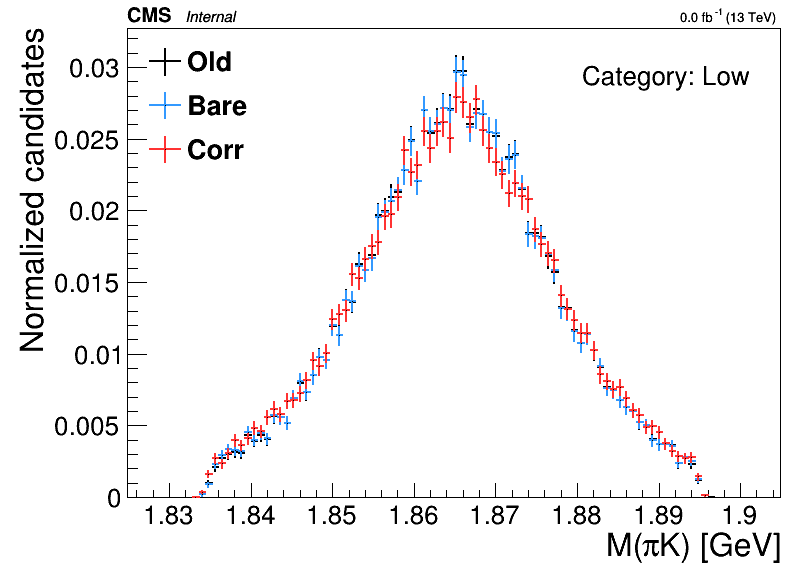

In [14]:
C = drawVar('mass_piK', binning=[100, m_D0-0.04, m_D0+0.04], xtitle='M(#piK) [GeV]')

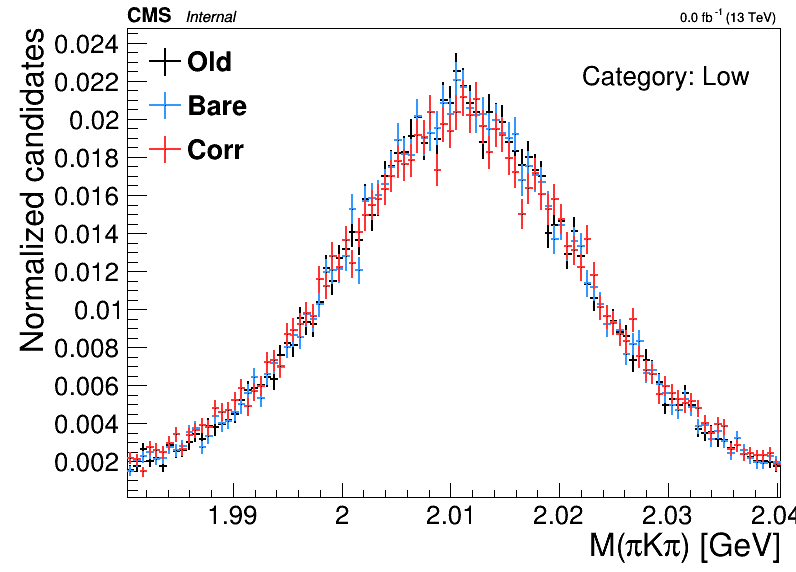

In [15]:
C = drawVar('mass_D0pis', binning=[100, m_Dst-0.03, m_Dst+0.03], xtitle='M(#piK#pi) [GeV]')

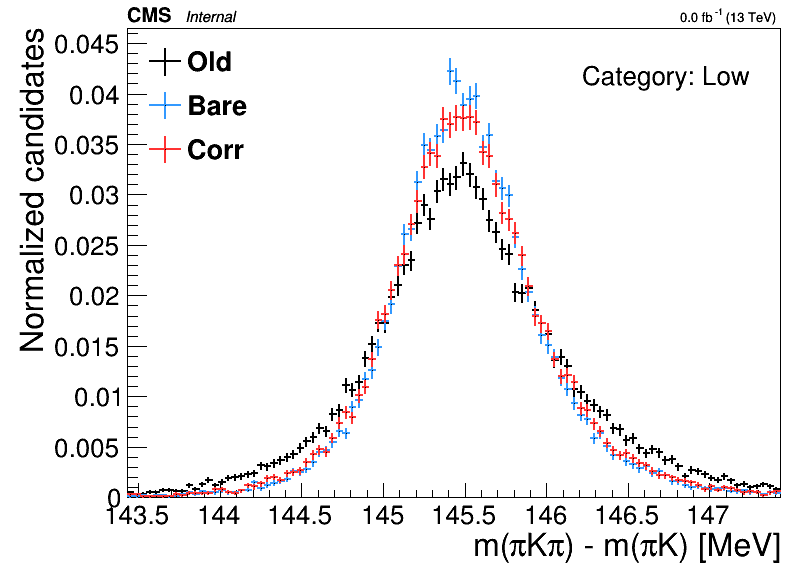

In [16]:
leg = rt.TLegend(0.18, 0.7, 0.4, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

opt='overflow+underflow'
hOld = create_TH1D(1e3*(df_old['mass_D0pis']-df_old['mass_piK']), 'old',
              binning=[100, 1e3*dm - 2, 1e3*dm + 2], 
              axis_title=['m(#piK#pi) - m(#piK) [MeV]', 'Normalized candidates'],
              scale_histo='norm',
              opt=opt
             )
leg.AddEntry(hOld, 'Old', 'lep')

hBare = create_TH1D(1e3*(df_bare['mass_D0pis']-df_bare['mass_piK']), 'bare', 
                    binning=hOld.binning, opt=opt, scale_histo='norm')
hBare.SetLineColor(col_dic['mu'])
leg.AddEntry(hBare, 'Bare', 'lep')

hCorr = create_TH1D(1e3*(df_corr['mass_D0pis']-df_corr['mass_piK']), 'corr', binning=hOld.binning, scale_histo='norm', opt=opt)
hCorr.SetLineColor(col_dic['tau'])
leg.AddEntry(hCorr, 'Corr', 'lep')

h_list = [hOld, hBare, hCorr]        

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))

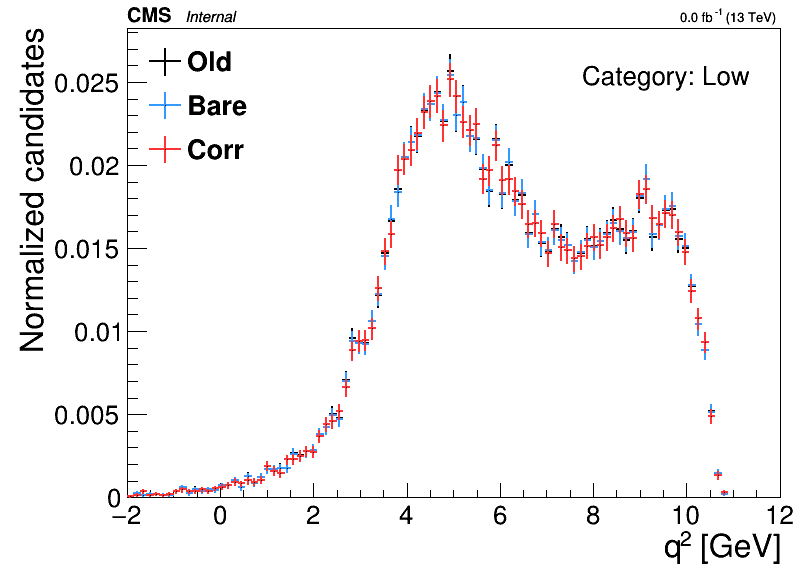

In [17]:
C = drawVar('q2', binning=[100, -2, 12], xtitle='q^{2} [GeV]')

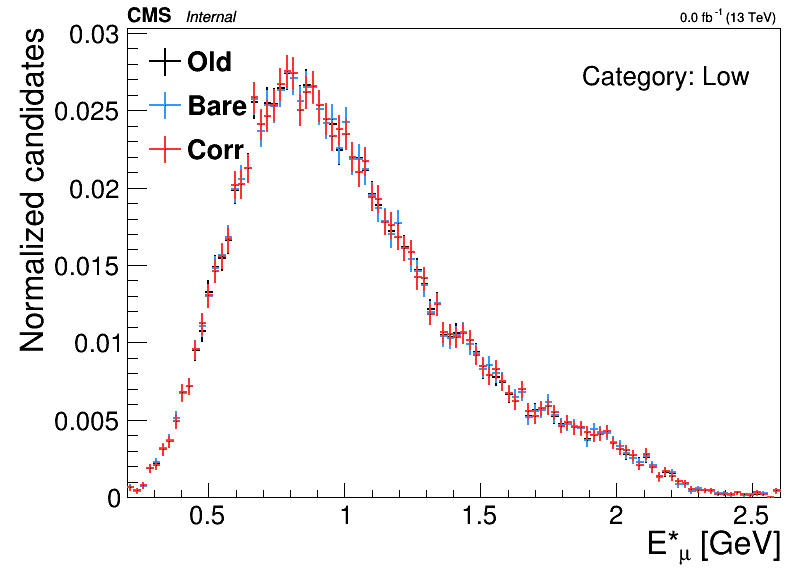

In [18]:
C = drawVar('Est_mu', binning=[100, 0.2, 2.6], xtitle='E*_{#mu} [GeV]')

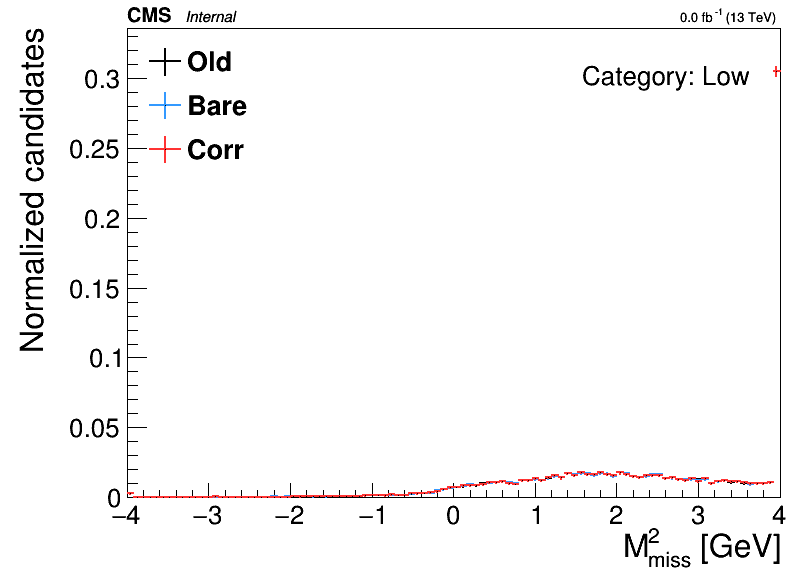

In [19]:
C = drawVar('M2_miss', binning=[100, -4, 4], xtitle='M^{2}_{miss} [GeV]')

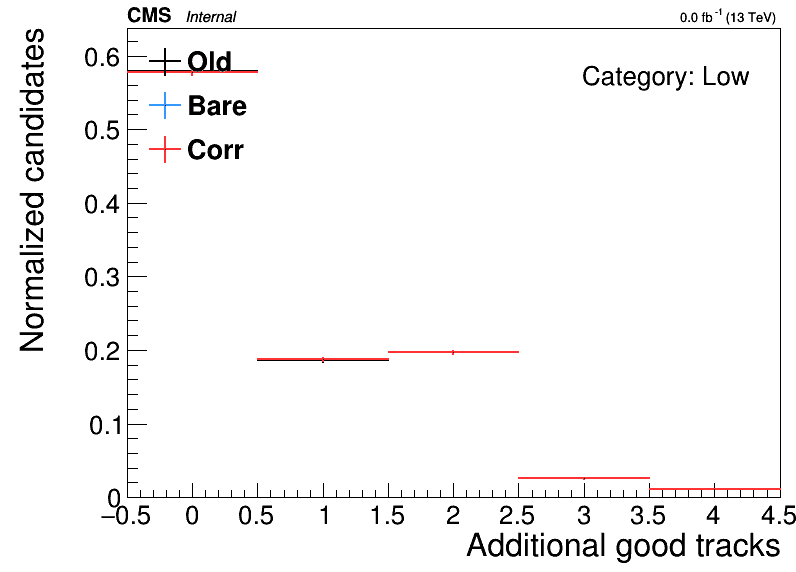

In [20]:
C = drawVar('N_goodAddTks', binning=[5, -0.5, 4.5], xtitle='Additional good tracks')

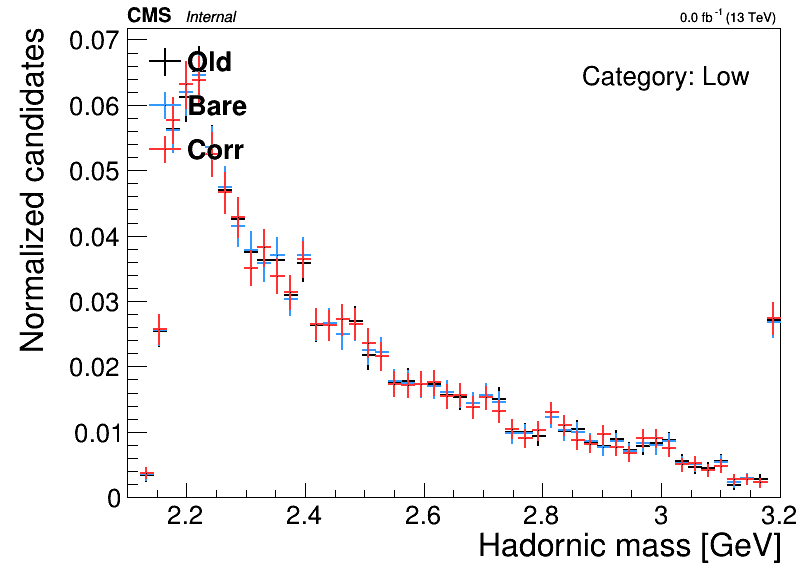

In [21]:
sel = []
for df in [df_old, df_bare, df_corr]:
    sel.append(df['N_goodAddTks']==1)
C = drawVar('tkMassHad_0', sel=sel, binning=[50, 2.1, 3.2], xtitle='Hadornic mass [GeV]')

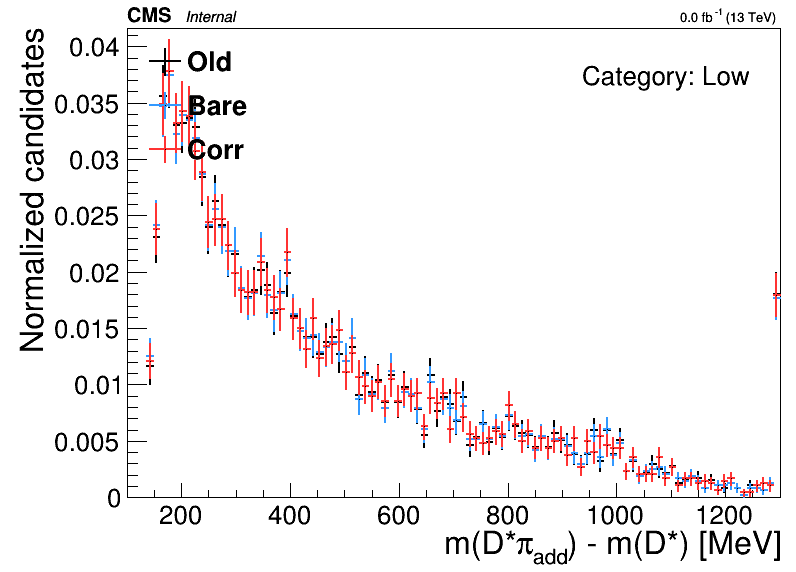

In [22]:
leg = rt.TLegend(0.18, 0.7, 0.4, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

opt='overflow+underflow'
hOld = create_TH1D(1e3*(df_old['tkMassHad_0']-df_old['mass_D0pis'])[sel[0]], 'old',
              binning=[100, 100, 1300], 
              axis_title=['m(D*#pi_{add}) - m(D*) [MeV]', 'Normalized candidates'],
              scale_histo='norm',
              opt=opt
             )
leg.AddEntry(hOld, 'Old', 'lep')

hBare = create_TH1D(1e3*(df_bare['tkMassHad_0']-df_bare['mass_D0pis'])[sel[1]], 'bare', 
                    binning=hOld.binning, opt=opt, scale_histo='norm')
hBare.SetLineColor(col_dic['mu'])
leg.AddEntry(hBare, 'Bare', 'lep')

hCorr = create_TH1D(1e3*(df_corr['tkMassHad_0']-df_corr['mass_D0pis'])[sel[2]], 'corr', binning=hOld.binning, scale_histo='norm', opt=opt)
hCorr.SetLineColor(col_dic['tau'])
leg.AddEntry(hCorr, 'Corr', 'lep')

h_list = [hOld, hBare, hCorr]        

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))